<a href="https://colab.research.google.com/github/shubhammane7777/Comparing-Algorithms-for-Credit-Risk-Prediction-/blob/main/Comparison_of_algorithms_of_credit_risk_for_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, precision_score, recall_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import warnings


 Load dataset

In [3]:

    file_path = '/content/drive/MyDrive/lending_club_small.csv'
    df = pd.read_csv(file_path, low_memory=False)

# Basic info
    print("Shape of data:", df.shape)
    df.head()


Shape of data: (40000, 144)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,7000.0,7000.0,7000.0,36 months,13.35,237.04,C,C2,9 years,RENT,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,6000.0,6000.0,6000.0,36 months,15.31,208.91,C,C2,NaN,OWN,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,14400.0,14400.0,14400.0,36 months,16.99,513.33,D,D1,1 year,RENT,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,12775.0,12775.0,12775.0,60 months,14.33,299.45,C,C2,2 years,OWN,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,9100.0,9100.0,9100.0,36 months,12.12,302.78,B,B3,3 years,RENT,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Data cleaning

In [4]:
# Drop columns with more than 50% missing values
null_percent = df.isnull().mean() * 100
cols_to_drop = null_percent[null_percent > 50].index
df.drop(columns=cols_to_drop, inplace=True)
print("Dropped columns with >50% missing values:", list(cols_to_drop))

# Drop irrelevant columns
irrelevant = ['id', 'member_id', 'url', 'desc', 'emp_title', 'title', 'zip_code']
df.drop(columns=[col for col in irrelevant if col in df.columns], inplace=True)
print("Shape of data:", df.shape)

Dropped columns with >50% missing values: ['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardshi

In [5]:
    print("Shape of data:", df.shape)
    df.head()

Shape of data: (40000, 89)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,7000.0,7000.0,7000.0,36 months,13.35,237.04,C,C2,9 years,RENT,...,33.3,0.0,0.0,78425.0,57438.0,21100.0,41625.0,N,Cash,N
1,6000.0,6000.0,6000.0,36 months,15.31,208.91,C,C2,NaN,OWN,...,63.6,0.0,0.0,17700.0,14709.0,16900.0,0.0,N,Cash,N
2,14400.0,14400.0,14400.0,36 months,16.99,513.33,D,D1,1 year,RENT,...,0.0,0.0,0.0,54012.0,45503.0,2300.0,44912.0,N,Cash,N
3,12775.0,12775.0,12775.0,60 months,14.33,299.45,C,C2,2 years,OWN,...,50.0,0.0,0.0,173310.0,19845.0,20800.0,11271.0,N,Cash,N
4,9100.0,9100.0,9100.0,36 months,12.12,302.78,B,B3,3 years,RENT,...,0.0,0.0,0.0,83168.0,53257.0,15800.0,58668.0,N,Cash,N


In [6]:
# Drop columns with more than 50% missing values
null_percent = df.isnull().mean() * 100
cols_to_drop = null_percent[null_percent > 50].index
df.drop(columns=cols_to_drop, inplace=True)
print("Dropped columns with >50% missing values:", list(cols_to_drop))

# Drop irrelevant columns
irrelevant = ['id', 'member_id', 'url', 'desc', 'emp_title', 'title', 'zip_code']
df.drop(columns=[col for col in irrelevant if col in df.columns], inplace=True)

# Strip and extract the numeric part from 'term' column
df['term'] = df['term'].str.extract('(\d+)').astype(float)

Dropped columns with >50% missing values: []


<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2320818976.py:12: SyntaxWarning: invalid escape sequence '\d'
  df['term'] = df['term'].str.extract('(\d+)').astype(float)


In [7]:
# Step 1: Check which columns are categorical
cat_cols = df.select_dtypes(include='object').columns
print("Categorical columns:", cat_cols.tolist())

Categorical columns: ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [8]:
# Step 2: Drop all categorical columns
df_numeric = df.drop(columns=cat_cols)

In [9]:
# Optional: Check remaining columns
print("Remaining numeric columns:", df_numeric.columns.tolist())

Remaining numeric columns: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'loan_status', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', '

In [10]:
# Now drop remaining categorical columns
cat_cols = df.select_dtypes(include='object').columns
df_numeric = df.drop(columns=cat_cols)

# Confirm
print("Remaining columns after drop:", df_numeric.columns.tolist())

Remaining columns after drop: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'loan_status', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl'

In [11]:
    df_numeric.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,7000.0,7000.0,7000.0,36.0,13.35,237.04,42000.0,1,13.60,2.0,...,0.0,1.0,71.0,33.3,0.0,0.0,78425.0,57438.0,21100.0,41625.0
1,6000.0,6000.0,6000.0,36.0,15.31,208.91,47000.0,0,13.66,0.0,...,0.0,1.0,100.0,63.6,0.0,0.0,17700.0,14709.0,16900.0,0.0
2,14400.0,14400.0,14400.0,36.0,16.99,513.33,36000.0,1,28.57,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,54012.0,45503.0,2300.0,44912.0
3,12775.0,12775.0,12775.0,60.0,14.33,299.45,40000.0,0,19.68,0.0,...,0.0,1.0,100.0,50.0,0.0,0.0,173310.0,19845.0,20800.0,11271.0
4,9100.0,9100.0,9100.0,36.0,12.12,302.78,45000.0,1,29.25,1.0,...,1.0,1.0,95.0,0.0,0.0,0.0,83168.0,53257.0,15800.0,58668.0


In [12]:
    X = df_numeric.drop('loan_status', axis=1)
    y = df_numeric['loan_status']

# Impute missing values using the mean
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns) # Convert back to DataFrame

    selector = SelectKBest(score_func=f_classif, k=10)
    X_selected_array = selector.fit_transform(X_imputed, y)
    selected_columns = X_imputed.columns[selector.get_support()]

    X_selected = pd.DataFrame(X_selected_array, columns=selected_columns)
    X_selected['loan_status'] = y.reset_index(drop=True)  # Add target back

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [18 19 31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Shape of dataset: (40000, 89)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   40000 non-null  float64
 1   funded_amnt                 40000 non-null  float64
 2   funded_amnt_inv             40000 non-null  float64
 3   term                        40000 non-null  float64
 4   int_rate                    40000 non-null  float64
 5   installment                 40000 non-null  float64
 6   grade                       40000 non-null  object 
 7   sub_grade                   40000 non-null  object 
 8   emp_length                  37381 non-null  object 
 9   home_ownership              40000 non-null  object 
 10  annual_inc                  40000 non-null  float64
 11  verification_status         40000 non-null  object 
 12  issue_d                     40000 non-null 

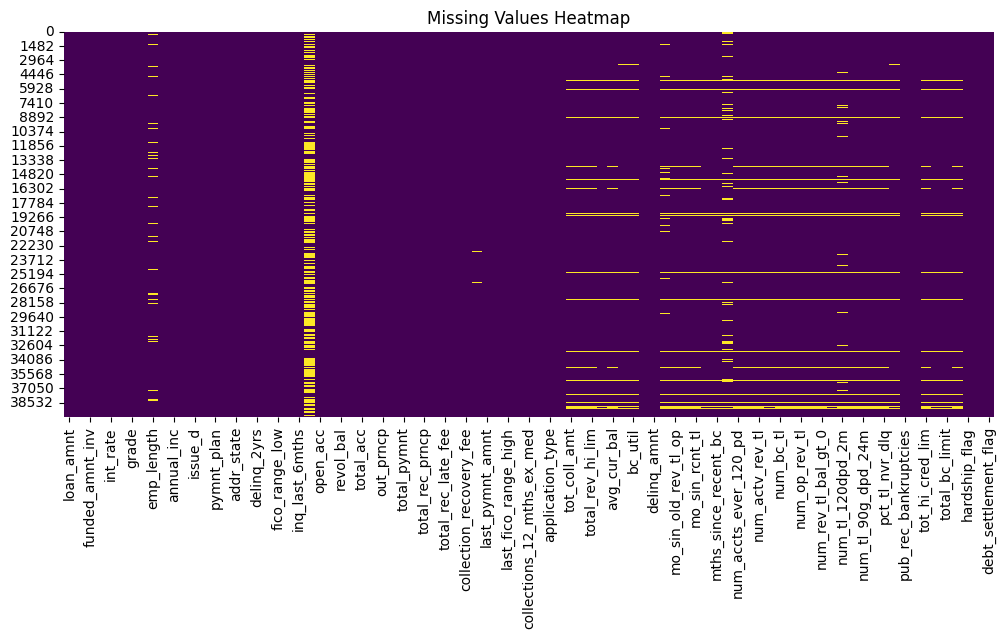

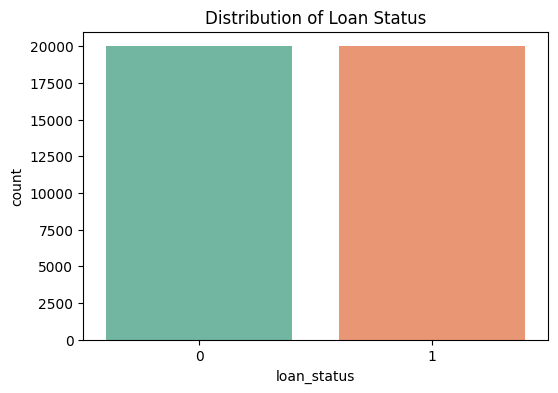

loan_status
1    0.5
0    0.5
Name: proportion, dtype: float64


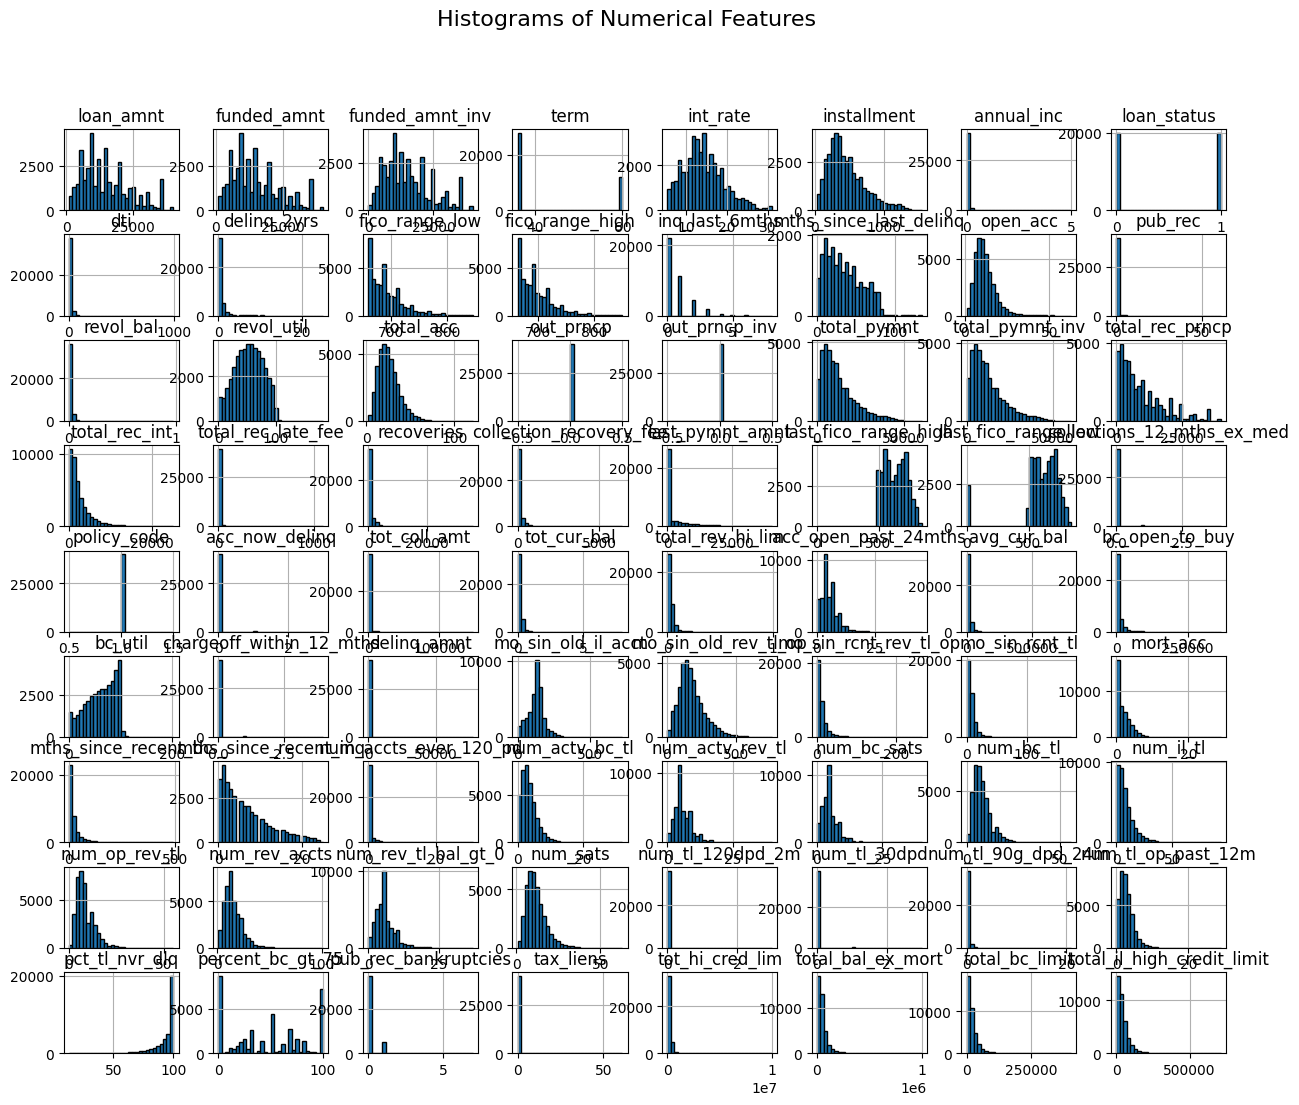

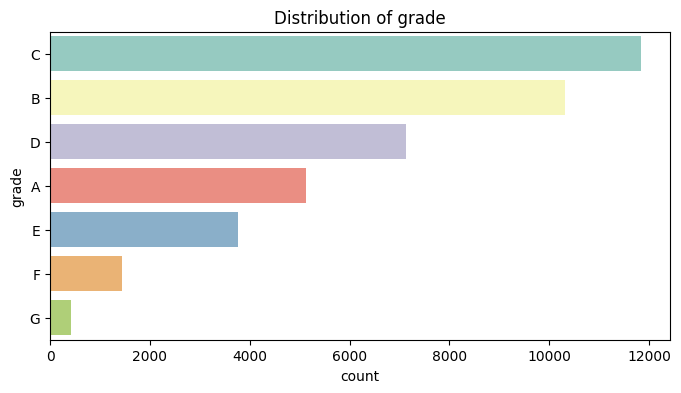

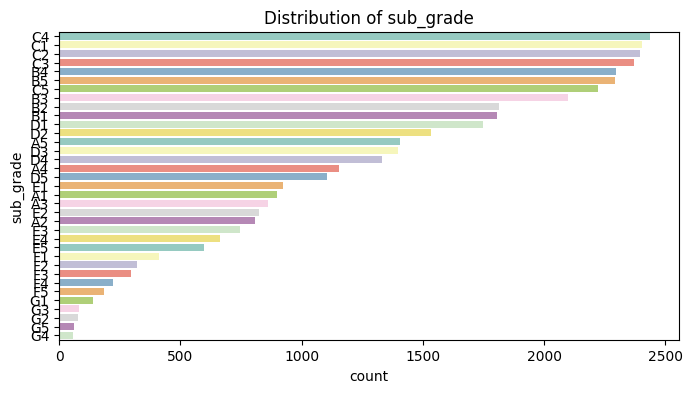

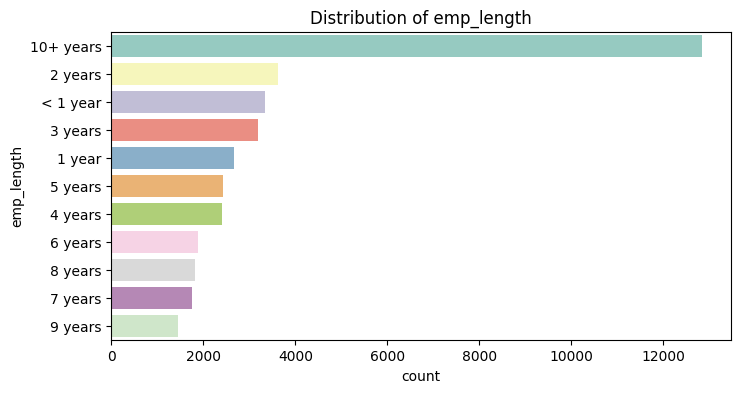

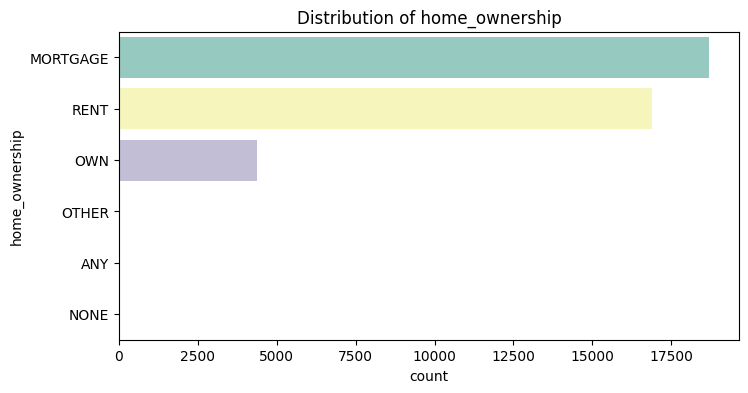

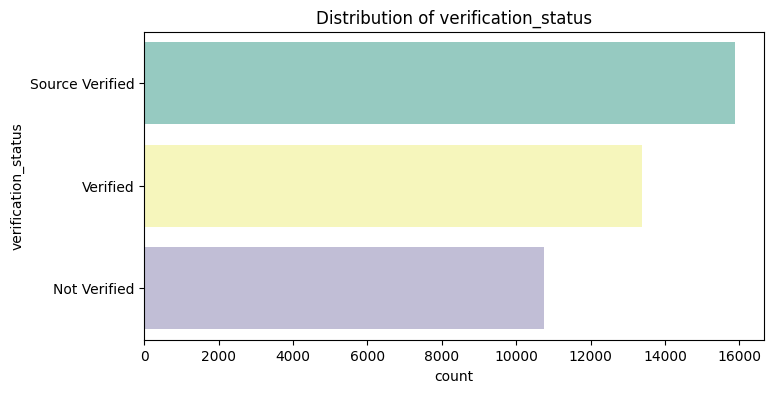

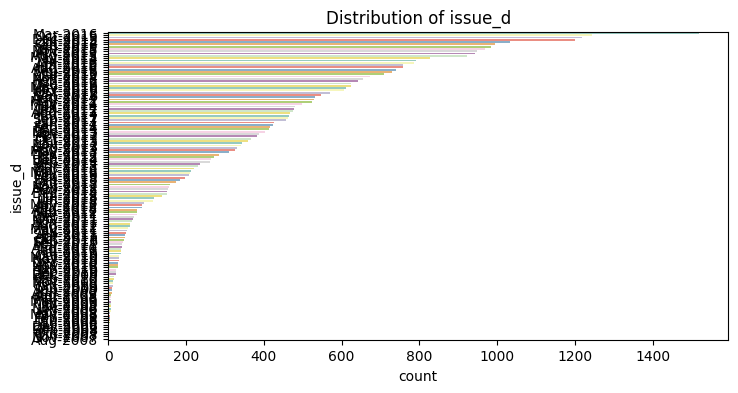

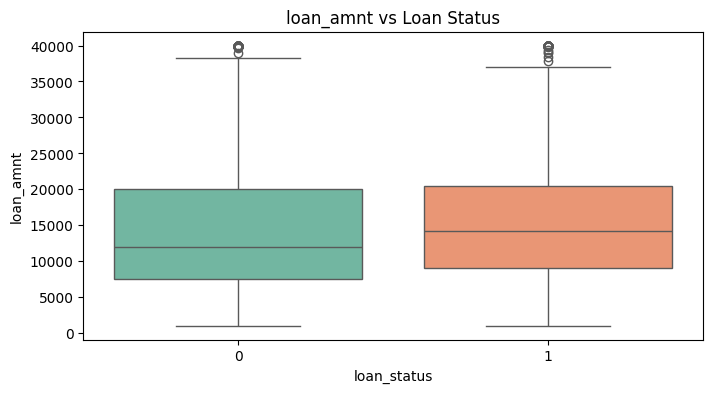

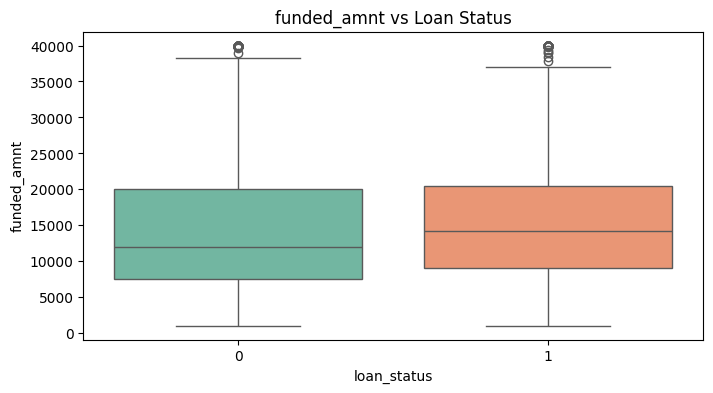

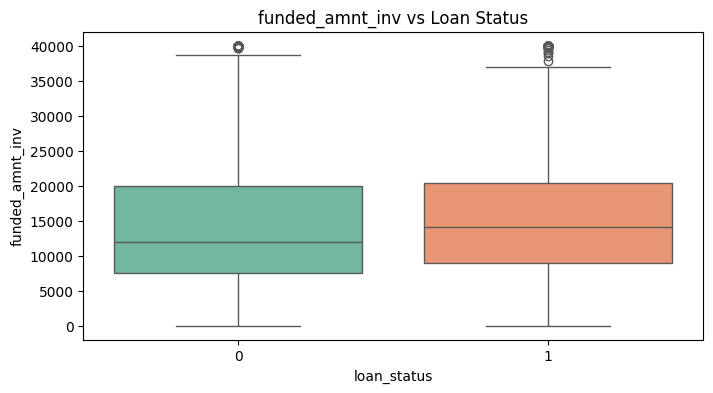

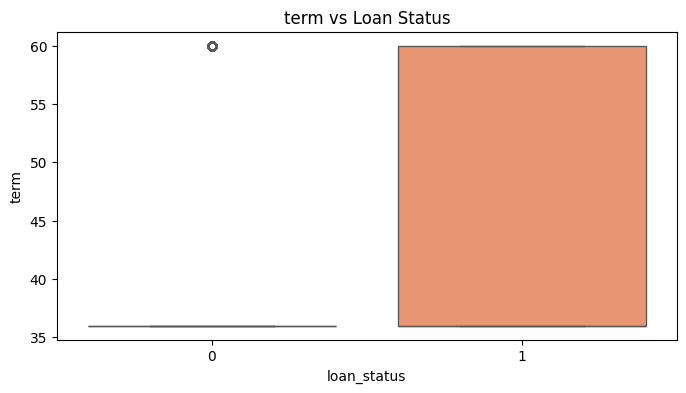

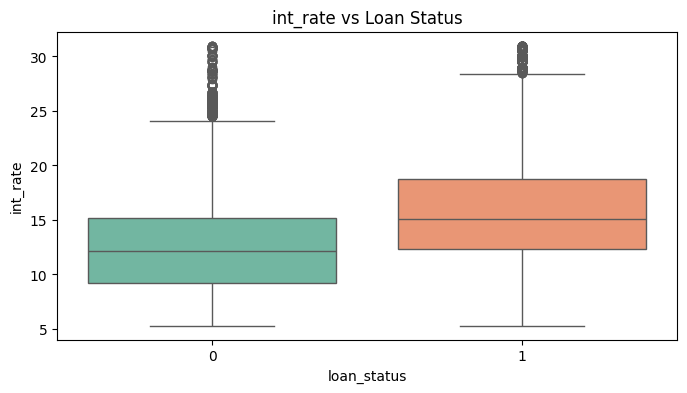

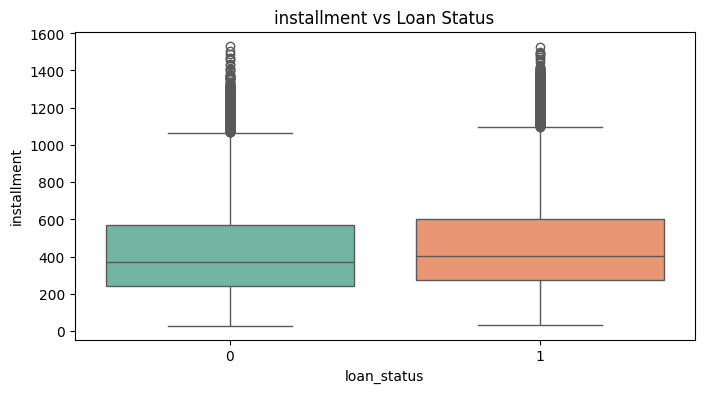

In [13]:
# 📊 Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")


# 1. Basic overview

print("Shape of dataset:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values (%):")
print(df.isnull().mean() * 100)


# 2. Missing values heatmap

plt.figure(figsize=(12,5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


# 3. Target variable distribution

if 'loan_status' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='loan_status', data=df, palette='Set2')
    plt.title("Distribution of Loan Status")
    plt.show()
    print(df['loan_status'].value_counts(normalize=True))


# 4. Numerical feature distributions

num_cols = df.select_dtypes(include=np.number).columns.tolist()

df[num_cols].hist(figsize=(15,12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()


# 5. Categorical feature distributions

cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

for col in cat_cols[:6]:  # show first 6 categorical features
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette="Set3")
    plt.title(f"Distribution of {col}")
    plt.show()


# 6. Numerical features vs Target

if 'loan_status' in df.columns:
    for col in num_cols[:6]:  # show first 6 numeric for readability
        plt.figure(figsize=(8,4))
        sns.boxplot(x='loan_status', y=col, data=df, palette="Set2")
        plt.title(f"{col} vs Loan Status")
        plt.show()



Feature Selection Plan
Correlation Matrix:


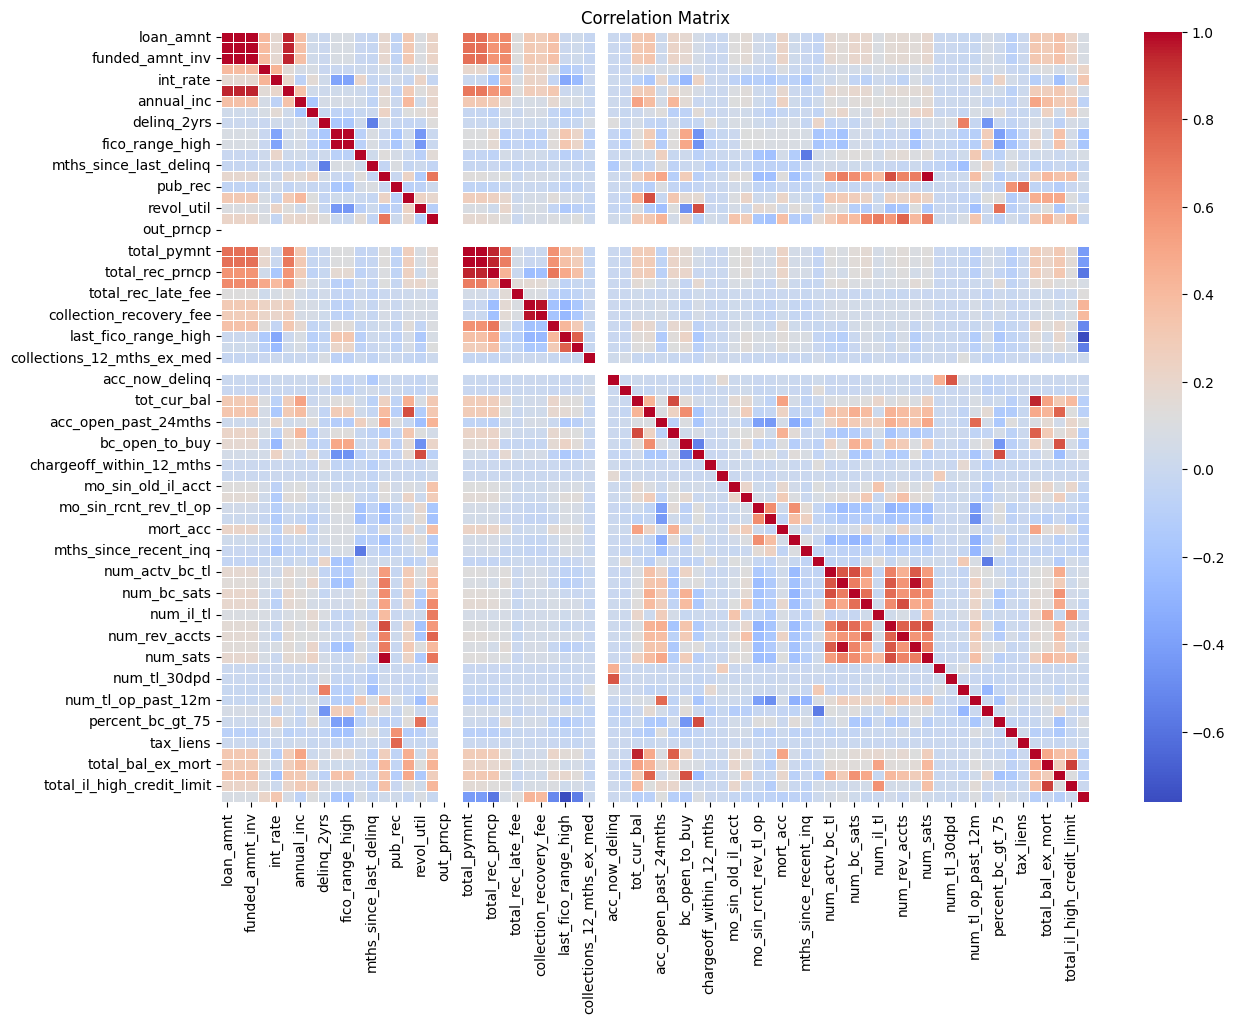

In [14]:
# Combine X and y to form a complete DataFrame
data = X.copy()
data['loan_status'] = y

# Compute correlation matrix
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Handling Class Imbalance

In [15]:
# Assuming X_selected and y are available from previous steps
# Use selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected.drop('loan_status', axis=1),
                                                    X_selected['loan_status'],
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=X_selected['loan_status'])
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: loan_status
1    14000
0    14000
Name: count, dtype: int64
After SMOTE: loan_status
1    14000
0    14000
Name: count, dtype: int64


Baseline Model Training and Evaluation

In [16]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()

Logistic Regression

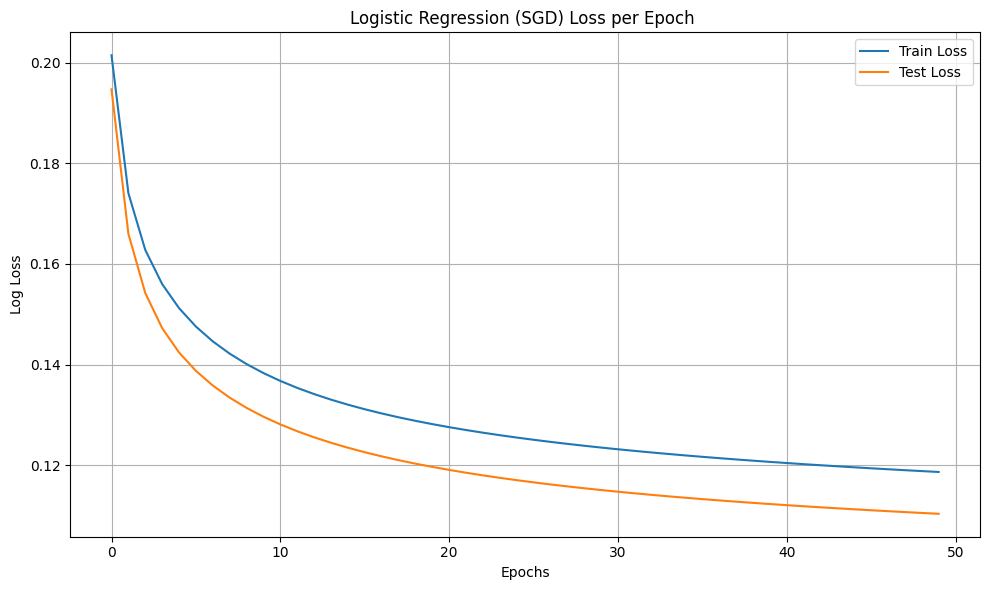


 SGD Logistic Regression Evaluation:
Accuracy:  0.9594166666666667
F1 Score:  0.9595414139735815
Precision:  0.9566009607420904
Recall:  0.9625
ROC-AUC Score: 0.9928279166666666


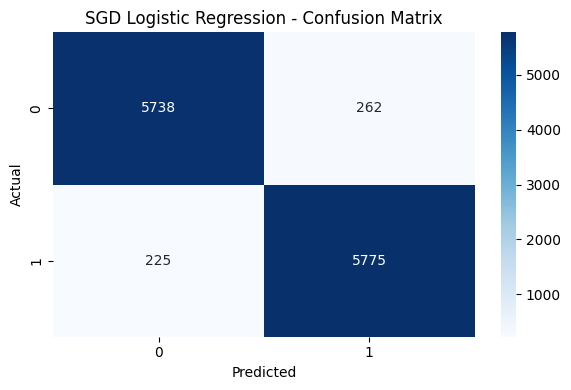

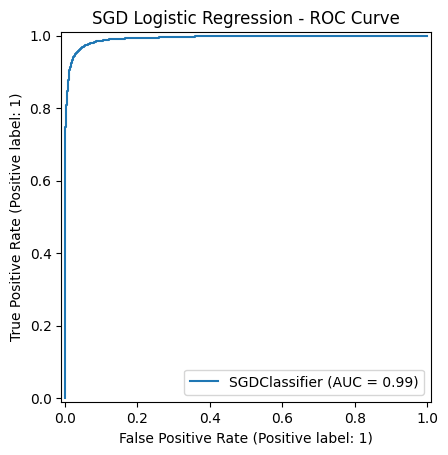

In [17]:
# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Step 1: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train with manual epochs using SGD
epochs = 50
train_losses, test_losses = [], []

model = SGDClassifier(loss='log_loss',
                      learning_rate='constant',
                      eta0=0.001,            # Smaller learning rate
                      max_iter=1,            # 1 epoch per .fit()
                      tol=None,              # Don't check convergence
                      warm_start=True,
                      average=True,          # Averaged SGD = smoother
                      random_state=42)

for epoch in range(epochs):
    model.fit(X_train_scaled, y_train_res)
    y_train_prob = model.predict_proba(X_train_scaled)
    y_test_prob = model.predict_proba(X_test_scaled)

    train_losses.append(log_loss(y_train_res, y_train_prob))
    test_losses.append(log_loss(y_test, y_test_prob))

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Logistic Regression (SGD) Loss per Epoch ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the evaluate_model function from a previous cell
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n {name} Evaluation:")
    print("Accuracy: ", model.score(X_test, y_test))
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'{name} - ROC Curve')
    plt.show()


evaluate_model("SGD Logistic Regression", model, X_test_scaled, y_test)

Random Forest

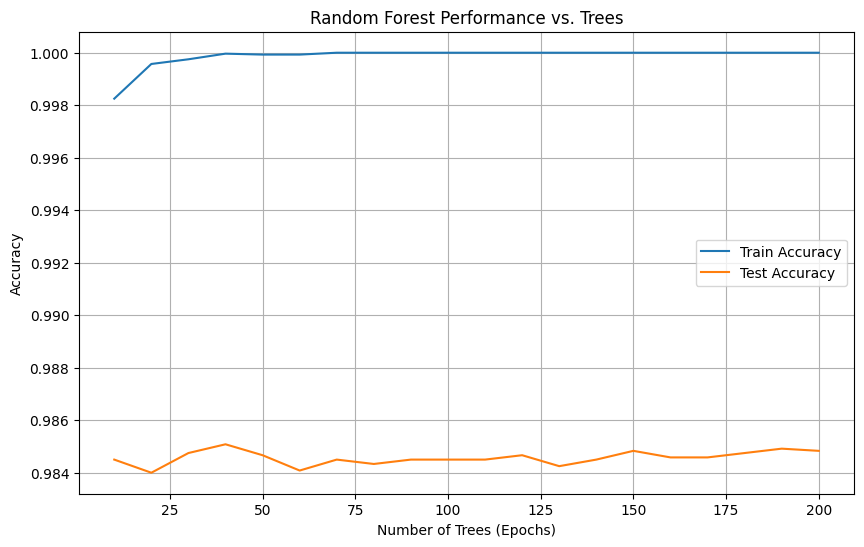


 Random Forest Evaluation:
Accuracy:  0.9848333333333333
F1 Score:  0.9848054767072967
Precision:  0.9866175978588156
Recall:  0.983
ROC-AUC Score: 0.9985691666666666


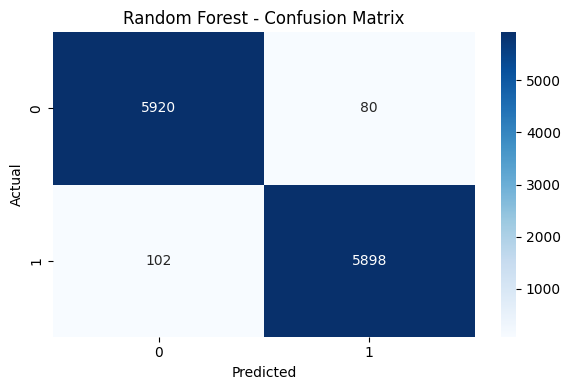

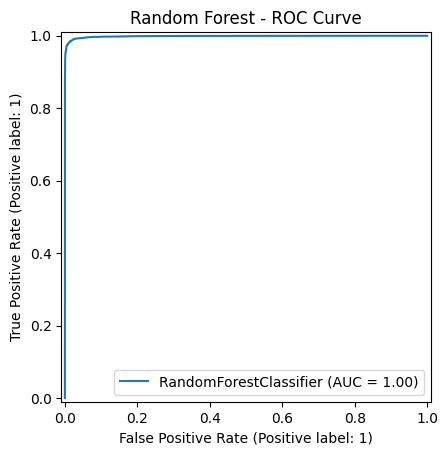

In [18]:
    train_accuracies = []
    test_accuracies = []
    estimators = range(10, 201, 10)

    for n in estimators:
        model = RandomForestClassifier(n_estimators=n, random_state=42)
        model.fit(X_train_res, y_train_res)
        train_accuracies.append(model.score(X_train_res, y_train_res))
        test_accuracies.append(model.score(X_test, y_test))

# Plot
    plt.figure(figsize=(10, 6))
    plt.plot(estimators, train_accuracies, label="Train Accuracy")
    plt.plot(estimators, test_accuracies, label="Test Accuracy")
    plt.xlabel("Number of Trees (Epochs)")
    plt.ylabel("Accuracy")
    plt.title("Random Forest Performance vs. Trees")
    plt.legend()
    plt.grid()
    plt.show()

    evaluate_model("Random Forest", model, X_test, y_test)

 XGBoost

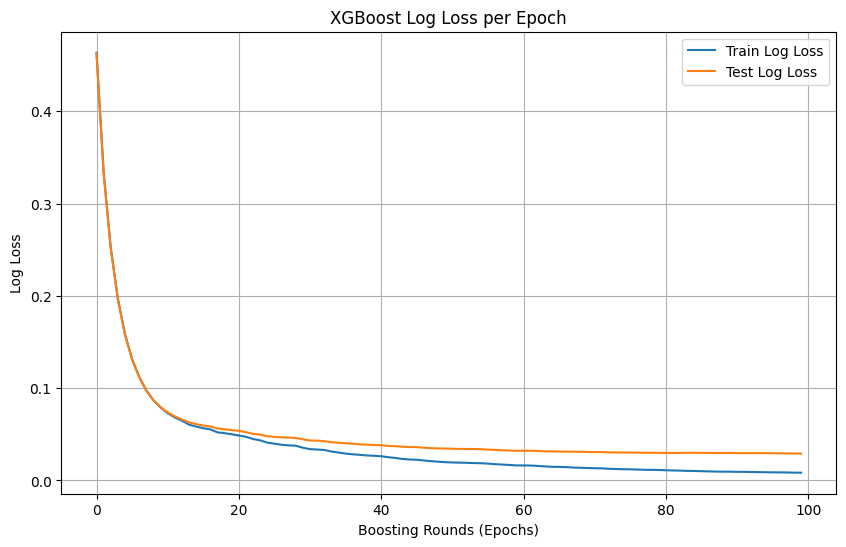


 XGBoost Evaluation:
Accuracy:  0.9905
F1 Score:  0.9904777814901436
Precision:  0.9927997320830543
Recall:  0.9881666666666666
ROC-AUC Score: 0.9991875277777778


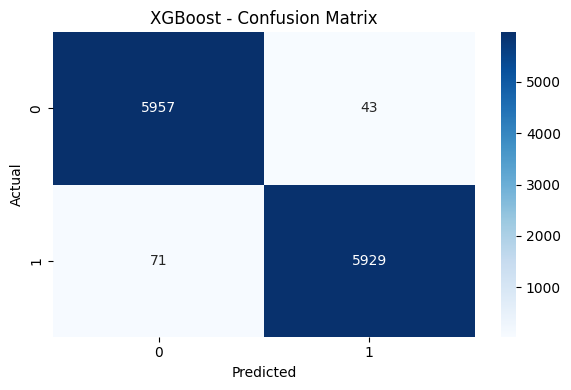

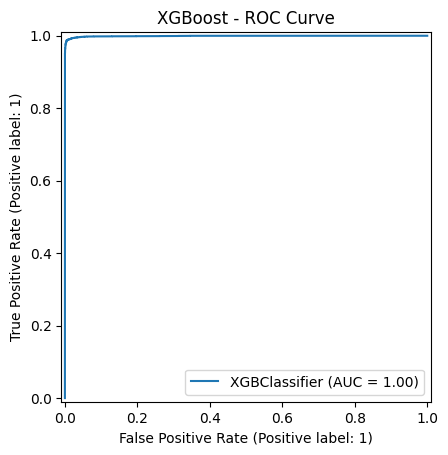

In [19]:
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100)
    xgb_model.fit(X_train_res, y_train_res,
                  eval_set=[(X_train_res, y_train_res), (X_test, y_test)],
                  verbose=False)

# Retrieve evaluation results from the fitted model
    results = xgb_model.evals_result()

# Plot log loss over epochs
    train_logloss = results['validation_0']['logloss']
    test_logloss = results['validation_1']['logloss']

    plt.figure(figsize=(10, 6))
    plt.plot(train_logloss, label='Train Log Loss')
    plt.plot(test_logloss, label='Test Log Loss')
    plt.xlabel("Boosting Rounds (Epochs)")
    plt.ylabel("Log Loss")
    plt.title("XGBoost Log Loss per Epoch")
    plt.legend()
    plt.grid()
    plt.show()

    evaluate_model("XGBoost", xgb_model, X_test, y_test)